In [1]:
%matplotlib inline
import numpy as np
from pathlib import Path
import qcodes as qc
import matplotlib.pyplot as plt

## Multidimensional scanning module
from qcodes.dataset import (
    Measurement,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)
## Dummy instruments for generating synthetic data
from qcodes.instrument_drivers.mock_instruments import (
    DummyInstrument,
    DummyInstrumentWithMeasurement,
)

## Using interactive widget
from qcodes.interactive_widget import experiments_widget

## Qcodes Data Acumulation Tutorial
The below commands are for setting up "dummy instruments." This means that they are simulators of instruments, in this case a signal generator and a multimeter, that have preprogrammed behaviors. This document is designed to use these dummy instruments to simply demonstrate the data measurement architecture and data saving we will use in QcOdEs. You don't need to fully understand these dummy instruments themselves, just the measurement structures.

In [2]:
# A dummy signal generator with two parameters ch1 and ch2
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])

# A dummy digital multimeter that generates a synthetic data depending
# on the values set on the setter_instr, in this case the dummy dac
dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)

dac.ch1(1.1)
dmm.v1()

3.908648297914218

The cell below is used to initialize an experiment for saving and reaccessing experiment data as well as assigning parameters for data saving.

In [3]:
#We start by stopping the laser pulsing. This way we can properly initialize.
initialise_or_create_database_at(Path.cwd() / "Experiment Name.db") #Experiment name for data saving file to open or create
experiment = load_or_create_experiment(
    experiment_name='Experiment Name',
    sample_name="" #Can use for sample names, but we don't vary the sample, so can be left blank
)
#Use this to make a parameter out of anything!
DAC = qc.ManualParameter('Setting', unit='V')
DMM = qc.ManualParameter('Signal', unit='V')
meas = Measurement(exp=experiment, name='Experiment Name')
meas.register_parameter(DAC)  # register the first independent parameter
meas.register_parameter(DMM)

In [10]:
dac_range = np.linspace(0, 10, 101)
with meas.run() as your_data: #This begins the experiment and assigns the name of your dataset.
    for dac_val in dac_range: #Your usual for loop to get a voltage to set the DAC to.
        ###########
        #Here you put any actions needed for each step of the experiment
        dac.ch1(dac_val)
        ###########
        #This is used for adding your results to your data set in the form (parameter, value).
        your_data.add_result((DAC, dac_val),
                             (DMM, dmm.v1()))
    output_data = your_data.dataset #Though you can directly use the variable your_data, if running several experiments, just note you can access the dataset values
                                    #By using this command.

Starting experimental run with id: 3. 


Once this is finished, you can convert this to a familier format and do your usual data analysis as shown below. Note that, depending on how you 

     Setting    Signal
0        0.0  5.086648
1        0.1  4.820098
2        0.2  4.842623
3        0.3  4.693679
4        0.4  4.601487
..       ...       ...
96       9.6  0.696452
97       9.7  0.800873
98       9.8  0.679918
99       9.9  0.655711
100     10.0  0.664698

[101 rows x 2 columns]


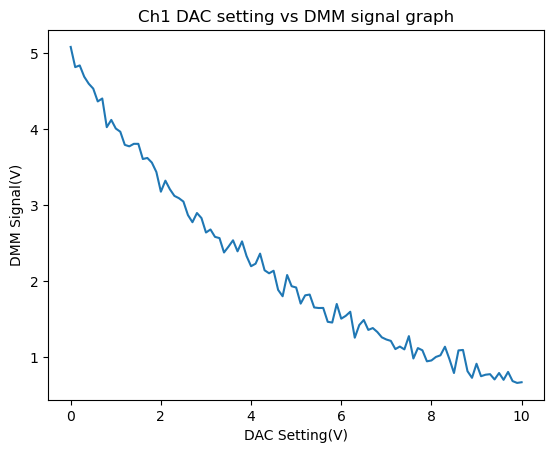

In [6]:
data = output_data.to_pandas_dataframe()
print(data)
plt.plot(data["Setting"], data["Signal"])
plt.xlabel('DAC Setting(V)')
plt.ylabel('DMM Signal(V)')
plt.title('Ch1 DAC setting vs DMM signal graph')
plt.show()

## Retreiving Data
Data retreival is very simple in this software. You are given an experimental run ID with every new run in a given experiment. To access the data, you can run the code block below with the desired run ID.

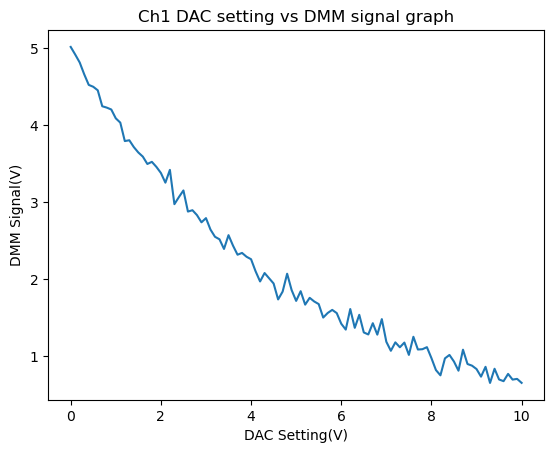

In [11]:
loaded_data = load_by_run_spec(captured_run_id=3) #Substitude 1 for the desired experiment number
panda_loaded_data = loaded_data.to_pandas_dataframe() #Converts data into a panda data frame.
plt.plot(panda_loaded_data["Setting"], panda_loaded_data["Signal"])
plt.xlabel('DAC Setting(V)')
plt.ylabel('DMM Signal(V)')
plt.title('Ch1 DAC setting vs DMM signal graph')
plt.show()

## Multiple Variables and Contour Maps
You can also do measurements with multiple variables.

In [12]:
initialise_or_create_database_at(Path.cwd() / "Experiment Name 2.db") #Experiment name for data saving file to open or create
experiment = load_or_create_experiment(
    experiment_name='Experiment Name 2',
    sample_name="" #Can use for sample names, but we don't vary the sample, so can be left blank
)
#Use this to make a parameter out of anything!
DAC1 = qc.ManualParameter('Setting1', unit='V')
DAC2 = qc.ManualParameter('Setting2', unit='V')
DMM = qc.ManualParameter('Signal', unit='V')
meas = Measurement(exp=experiment, name='Experiment Name 2')
meas.register_parameter(DAC1)
meas.register_parameter(DAC2)
meas.register_parameter(DMM)

Starting experimental run with id: 2. 


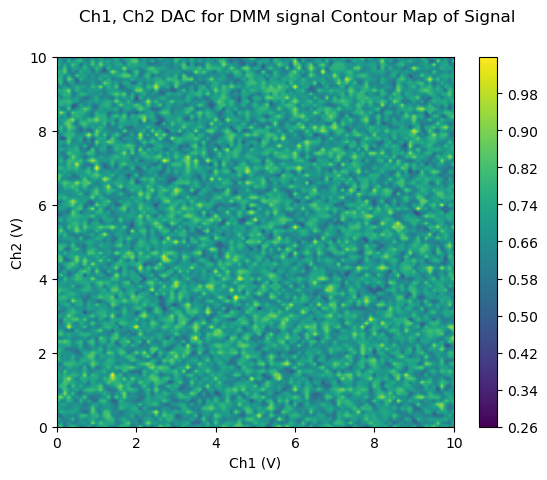

In [14]:
dac_range1 = np.linspace(0, 10, 101)
dac_range2 = np.linspace(0, 10, 101)
with meas.run() as your_data: #This begins the experiment and assigns the name of your dataset.
    for dac1_val in dac_range1:
        
        for dac2_val in dac_range2: #Your usual for loop to get a voltage to set the DAC to.
            ###########
            #Here you put any actions needed for each step of the experiment
            dac.ch1(dac_val)
            dac.ch2(dac_val)
            ###########
            #This is used for adding your results to your data set in the form (parameter, value).
            your_data.add_result((DAC1, dac1_val),
                                 (DAC2, dac2_val),
                                 (DMM, dmm.v1()))
        output_data = your_data.dataset

graph_data = output_data.to_pandas_dataframe()
fig=plt.figure()
dac_ch1_dim=np.linspace(dac_range1[0], dac_range1[-1], len(dac_range1))
dac_ch2_dim=np.linspace(dac_range2[0], dac_range2[-1], len(dac_range2))
dac1, dac2 = np.meshgrid(dac_ch1_dim, dac_ch2_dim)
sig = np.add(list(graph_data["Signal"]), 0)
sig = sig.reshape(len(dac_ch1_dim),len(dac_ch2_dim)).T 
plt.contourf(dac1, dac2, sig, 500) #The number chosen will give differeing 

fig.suptitle('Ch1, Ch2 DAC for DMM signal Contour Map of Signal')
plt.xlabel('Ch1 (V)')
plt.ylabel('Ch2 (V)')                              
plt.colorbar()
#plt.pcolormesh(dac1, dac2, sig, shading='auto', cmap='Blues') #Can be used to change the color
fig.canvas.draw_idle()

The data here is simply just noise, so there isn't any point reading into it. Following a procedure similar to this, you can aquire data in such a way that you can get 3D graphs or color graphs similar to the one above.